## K-Nearest Neighbors (KNN)

In [2]:
# Import all required libraries
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [3]:
# Import feature and target columns
X = pickle.load(open("./common/feature_status.p", "rb"))
y = pickle.load(open("./common/target_status.p", "rb"))
feature_cols = pickle.load(open("./common/feature_cols.p", "rb"))

### Perform Cross Validation

In [4]:
# Function to create the model, required for KerasClassifier
def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim=len(feature_cols), activation='relu')) # input_dim should be the number of features
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [5]:
# Create the KerasClassifier
clf_cv = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)

C:\Users\dell\AppData\Local\Temp\ipykernel_33228\2558005620.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf_cv = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)


In [6]:
# Define the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [7]:
# Evaluate the model
n_scores = cross_val_score(clf_cv, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [8]:
# Report the performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.876 (0.114)


### Train the model

In [9]:
# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Create the KerasClassifier
clf = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)

C:\Users\dell\AppData\Local\Temp\ipykernel_33228\3947378117.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)


In [11]:
# Fit the model to the training data
clf.fit(X_train, y_train)

In [12]:
# Use the model to make predictions on the test set
y_pred = clf.predict(X_test)

14/14 [==============================] - 0s 1ms/step


In [18]:
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>


In [14]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.9584295612009238
Precision: 0.7857142857142857
Recall: 0.6470588235294118


### Visualize the model

In [15]:
clf_matrix = confusion_matrix(y_test, y_pred)
clf_matrix

array([[393,   6],
       [ 12,  22]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted Label')

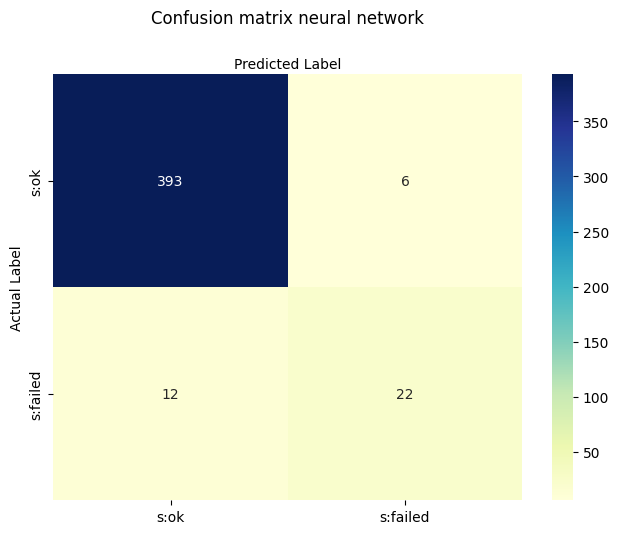

In [16]:
# Assuming clf_matrix is the confusion matrix you've computed
clf_matrix_df = pd.DataFrame(clf_matrix, index=["s:ok", "s:failed"], columns=["s:ok", "s:failed"])

# Create heatmap
class_names=["s:ok", "s:failed"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(clf_matrix_df, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")

plt.tight_layout()
plt.title('Confusion matrix neural network', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

### Export the model

In [17]:
pickle.dump(clf, open("./models/neural_network.p", "wb"))